In [124]:
import os
import scipy.io
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg
mat_contents = scipy.io.loadmat(os.path.join('..', 'DATA','VORTALL.mat'))

In [125]:
vortall = mat_contents['VORTALL']
print(np.shape(vortall))
U, S, VT = np.linalg.svd(vortall, full_matrices=False)

(89351, 151)


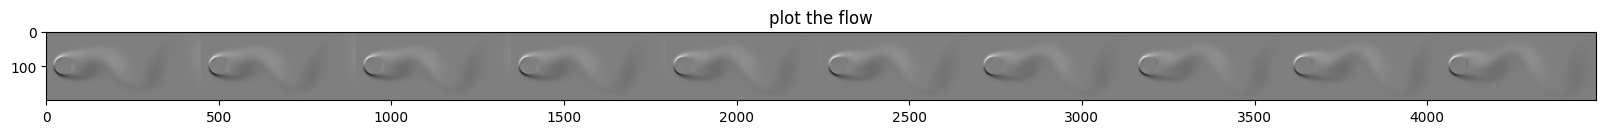

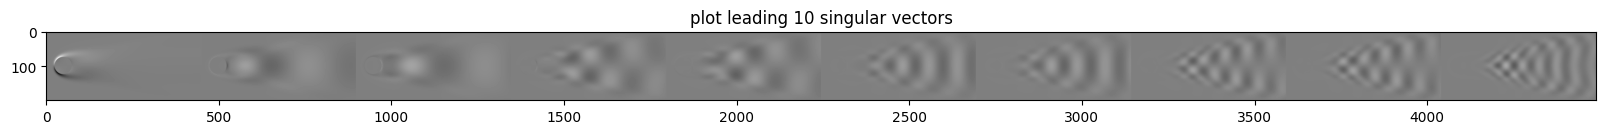

In [126]:
#1.7 (a) 
#plot flow and singular vectors
m = 449
n = 199
start = 0
r = 10
plt.rcParams['figure.figsize'] = (20,10)
#plot the flow
vortall_org = np.zeros((n, m*(r-start)))
for j in range(r-start):
    vortall_org[:, j*m:(j+1)*m] = np.transpose(np.reshape(vortall[:,j+start],(m,n)))
img = plt.imshow(vortall_org)
img.set_cmap('gray')
plt.title("plot the flow")
plt.show()

#plot eigen vctors
tenEigenVec_econ = np.zeros((n, m*(r-start)))
for j in range(r-start):
    tenEigenVec_econ[:, j*m:(j+1)*m] = np.transpose(np.reshape(U[:,j+start],(m,n)))
img = plt.imshow(tenEigenVec_econ)
img.set_cmap('gray')
plt.title("plot leading 10 singular vectors")
plt.show()



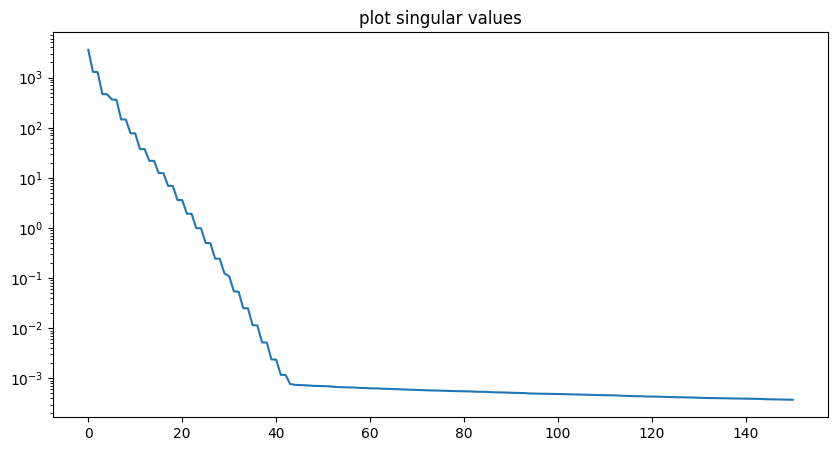

In [127]:
#plot singular values
plt.rcParams['figure.figsize'] = (10,5)
plt.semilogy(S)
plt.title('plot singular values')
plt.show()

In [128]:
#amplitudes
SVT = np.diag(S) @ VT

In [129]:
#1.7 (b)
#plot original movie
from PIL import Image
flow = []
for i in range(150):
    img = np.copy(np.real(np.reshape(vortall[:,i],(449,199))))
    flow.append(Image.fromarray(255*img))
flow[0].save("flow.gif", save_all=True, append_images=flow[1:], duration=50, loop=0)

In [130]:
#plot reconstruction movie
rank = [1, 2, 5, 10, 20, 50, 100]
for r in rank:
    rec = U[:,:r] @ np.diag(S[:r]) @ VT[:r,:]
    flow = []
    for i in range(150):
        img = np.copy(np.real(np.reshape(rec[:,i],(449,199))))
        temp = img*255
        flow.append(Image.fromarray(temp))
    flow[0].save('rec_rank'+ str(r) + '.gif', save_all=True, append_images=flow[1:], duration=50, loop=0)


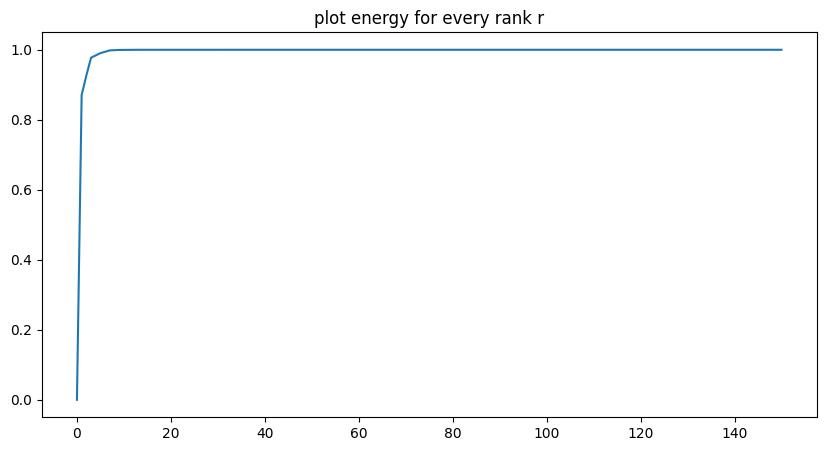

where rank r capture 0.90 energy: [2]
where rank r capture 0.99 energy: [5]
where rank r capture 0.999 energy: [9]


In [132]:
#rank r where caputure 90% 99% 99.9% of flow energy
#Frobenius norm of a matrix is equal to L2 norm
energy = [0.9, 0.99, 0.999]
energy_all = np.zeros(151)
for r in range(151):
    energy_all[r] = np.linalg.norm(S[:r])/np.linalg.norm(S)
plt.plot(energy_all)
plt.title('plot energy for every rank r')
plt.show()
print('where rank r capture 0.90 energy:', np.argwhere(energy_all>0.90)[0])
print('where rank r capture 0.99 energy:', np.argwhere(energy_all>0.99)[0])
print('where rank r capture 0.999 energy:', np.argwhere(energy_all>0.999)[0])


In [134]:
#plot movie with rank 2, 5, 9 corresponding to energy 90% 99% 99.9%
rank = [2,5,9]
for r in rank:
    rec = U[:,:r] @ np.diag(S[:r]) @ VT[:r,:]
    flow = []
    for i in range(150):
        img = np.copy(np.real(np.reshape(rec[:,i],(449,199))))
        temp = img*255
        flow.append(Image.fromarray(temp))
    flow[0].save('rec_rank'+ str(r) + '.gif', save_all=True, append_images=flow[1:], duration=50, loop=0)


In [135]:
#Frobenius norm of error
rank = [2,5,9]
for r in rank:
    rec = U[:,:r] @ np.diag(S[:r]) @ VT[:r,:]
    err = np.linalg.norm(rec - vortall, 'fro')
    print(err)


1546.2390001156718
566.0167511255213
126.67393770187134


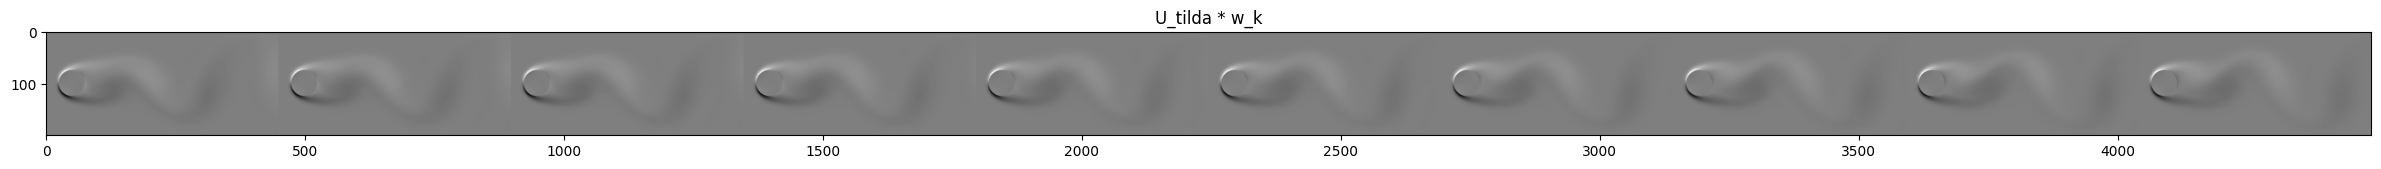

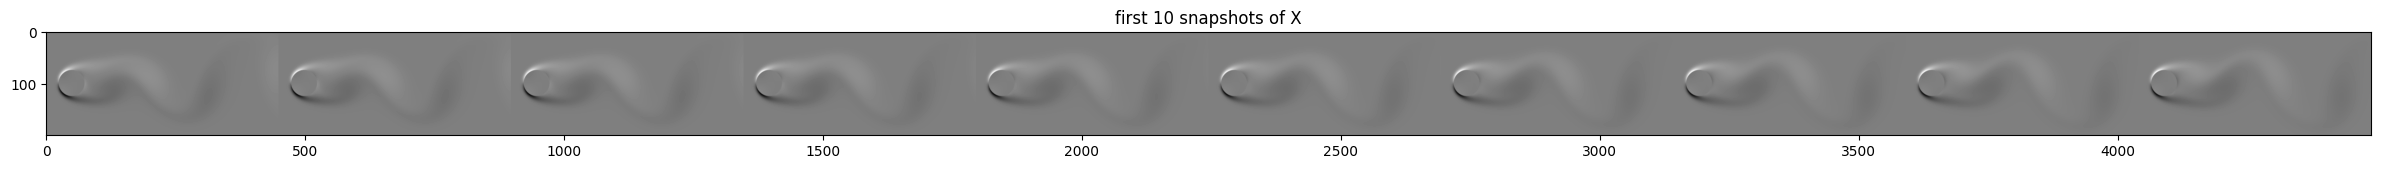

In [136]:
#1.7 (c)
#fix r = 10, compute truncated SVD
#each column of W = sigma~ * VT~ represent mixture of 10 eigenflows in the column of X
m = 449
n = 199
r_fix = 10
W = np.diag(S[:r_fix]) @ VT[:r_fix,:]


plt.rcParams['figure.figsize'] = (30,10)
#plot U_tilda * w_k
eigenflow = np.zeros((n, m*r_fix))
for j in range(r_fix):
    UWk = U[:,:r_fix] @ W[:,j]
    eigenflow[:, j*m:(j+1)*m] = np.transpose(np.reshape(UWk,(m,n)))
img = plt.imshow(eigenflow)
img.set_cmap('gray')
plt.title("U_tilda * w_k")
plt.show()

#plot first 10 snapshots of X
X = np.zeros((n, m*r_fix))
for j in range(r_fix):
    X[:, j*m:(j+1)*m] = np.transpose(np.reshape(vortall[:,j],(m,n)))
img = plt.imshow(X)
img.set_cmap('gray')
plt.title("first 10 snapshots of X")
plt.show()

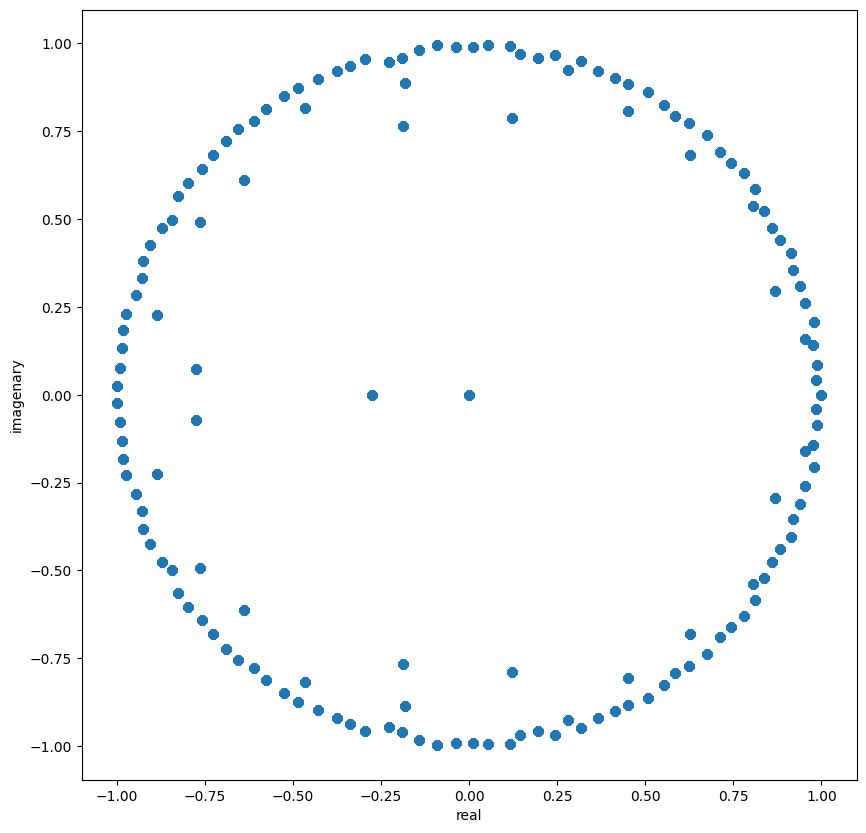

In [139]:
#1.7 (d)
#compute A = W' * W_pseudo and plot eigenvalues of A
W0 = np.diag(S) @ VT
W1 = W0[:, :-1]
W2 = W0[:, 1:]
W_U, W_S, W_VT = np.linalg.svd(W1, full_matrices=False)
W_PseInv = np.transpose(W_VT) @ np.linalg.inv(np.diag(W_S)) @ np.transpose(W_U)
A = W2 @ W_PseInv
A_eigvl, A_eigvc = np.linalg.eig(A)

x = [A_eigvl.real for ele in A_eigvl]
y = [A_eigvl.imag for ele in A_eigvl]
plt.rcParams['figure.figsize'] = (10,10)
plt.scatter(x,y)
plt.ylabel('imagenary')
plt.xlabel('real')
plt.show()

In [140]:
#1.7 (e) use w_k = A^(k-1) * w_1 to compute every w_k
W_tilda = np.zeros((151,151))
for i in range(151):
    W_tilda[:,i] = np.linalg.matrix_power(A, i) @ W1[:,0]

#reconstruct X by U_tilda * W
pred_flow = []
pred_X = U @ W_tilda
for i in range(151):
    img = np.copy(np.real(np.reshape(pred_X[:,i],(449,199))))
    pred_flow.append(Image.fromarray(255*img))
pred_flow[0].save("pred_flow.gif", save_all=True, append_images=pred_flow[1:], duration=50, loop=0)